![Mushrooms](https://i.postimg.cc/5tHPfftL/Stock-Cake-Mystical-Forest-Mushrooms-1723651159.jpg)

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from category_encoders.target_encoder import TargetEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

# Read and View Data

In [2]:
train = pd.read_csv(r"/kaggle/input/playground-series-s4e8/train.csv", index_col = 'id')
test = pd.read_csv(r"/kaggle/input/playground-series-s4e8/test.csv", index_col = 'id')
sample_submission = pd.read_csv(r"/kaggle/input/playground-series-s4e8/sample_submission.csv", index_col = 'id')

print("train data :", train.shape)
print("test data :", test.shape)
print("sample_submission_data :", sample_submission.shape)

train data : (3116945, 21)
test data : (2077964, 20)
sample_submission_data : (2077964, 1)


In [3]:
sample_submission.head(5)

,class
id,
3116945,e
3116946,e
3116947,e
3116948,e
3116949,e


In [4]:
train.info()

train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 523.2+ MB


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [5]:
test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3116948,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u
3116949,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


# Check NaN Entries Percentage

In [6]:
def null_percent(df):
    per=((df.isnull().sum()/len(df))*100).round(2)
    return per
print("Nan Values in Train data")
print(null_percent(train))
print("Nan Values in Test data")
print(null_percent(test))

Nan Values in Train data
class                    0.00
cap-diameter             0.00
cap-shape                0.00
cap-surface             21.53
cap-color                0.00
does-bruise-or-bleed     0.00
gill-attachment         16.81
gill-spacing            40.37
gill-color               0.00
stem-height              0.00
stem-width               0.00
stem-root               88.45
stem-surface            63.55
stem-color               0.00
veil-type               94.88
veil-color              87.94
has-ring                 0.00
ring-type                4.13
spore-print-color       91.43
habitat                  0.00
season                   0.00
dtype: float64
Nan Values in Test data
cap-diameter             0.00
cap-shape                0.00
cap-surface             21.51
cap-color                0.00
does-bruise-or-bleed     0.00
gill-attachment         16.83
gill-spacing            40.40
gill-color               0.00
stem-height              0.00
stem-width               0.00
stem-r

# Similarity in NaN values of train and test data columns

*If this is something new for you and you have came accross this scenario first time then it might be interesting for you.*

**Could it be Synthetic Data or is it just similarity of NaN in train and test?**

Both train and test data shows similarity in missing data. After trying different techniques to fill the missing data and dropping columns which had more than 80% missing values. I found that it was reducing the score on leader board. 
As the details of competition says it is synthetically generated data so, probabbly in case of this specific data, if we train the model with NaN values in training data than it performs well with NaN values of test data. 
Please note that in our specific case both train and test data have smililarity in missing values thus in this specific scenario it can perform well. If both data sets don't have this similarity in missing values then it can't perform well with NaN values.

I hope you got the point but incase you still want to dig deep into it, you can check previous versions of this note book to get an idea.

# Encode Categorical Columns

In [7]:
train['class'] = train['class'] =='p'

encoder  = TargetEncoder()
cat_features = [val for val in train.drop(columns = 'class').select_dtypes(exclude ='number').columns]
for feature in cat_features:
    train[feature] = encoder.fit_transform(train[feature], train['class'])
    test[feature] = encoder.transform(test[feature])
    

# Outlier Analysis
We will analyse outlier with two methods
1. Inter Quartile Range Method
2. Z-Score Method

**Inter Quartile Range Method**

In [8]:
# Assuming 'data' is your DataFrame and you want to find outliers in all numerical columns

def find_outliers_iqr(data):
    outliers = pd.DataFrame()

    for column in data.select_dtypes(include=[float, int]).columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        outliers[column] = ((data[column] < lower_bound) | (data[column] > upper_bound))

    return outliers

# Example usage
outliers = find_outliers_iqr(test)  # Replace 'test' with your DataFrame
print(outliers)

         cap-diameter  cap-shape  cap-surface  cap-color  \
id                                                         
3116945         False      False        False      False   
3116946         False       True        False      False   
3116947         False       True        False      False   
3116948         False      False        False      False   
3116949         False      False        False      False   
...               ...        ...          ...        ...   
5194904         False      False        False      False   
5194905         False      False        False      False   
5194906         False      False        False      False   
5194907         False       True        False      False   
5194908         False      False        False      False   

         does-bruise-or-bleed  gill-attachment  gill-spacing  gill-color  \
id                                                                         
3116945                  True            False         False       

**Z-Score Method**

In [9]:
def find_outliers_zscore(data, threshold=30):
    outliers = pd.DataFrame()

    for column in data.select_dtypes(include=[float, int]).columns:
        z_scores = np.abs(stats.zscore(data[column].dropna()))
        outliers[column] = z_scores > threshold

    return outliers

# Example usage
outliers = find_outliers_zscore(test)  # Replace 'test' with your DataFrame
print(outliers)

         cap-diameter  cap-shape  cap-surface  cap-color  \
id                                                         
3116945         False      False        False      False   
3116946         False      False        False      False   
3116947         False      False        False      False   
3116948         False      False        False      False   
3116949         False      False        False      False   
...               ...        ...          ...        ...   
5194904         False      False        False      False   
5194905         False      False        False      False   
5194906         False      False        False      False   
5194907         False      False        False      False   
5194908         False      False        False      False   

         does-bruise-or-bleed  gill-attachment  gill-spacing  gill-color  \
id                                                                         
3116945                 False            False         False       

# Data Visualization

<Axes: xlabel='stem-height', ylabel='stem-width'>

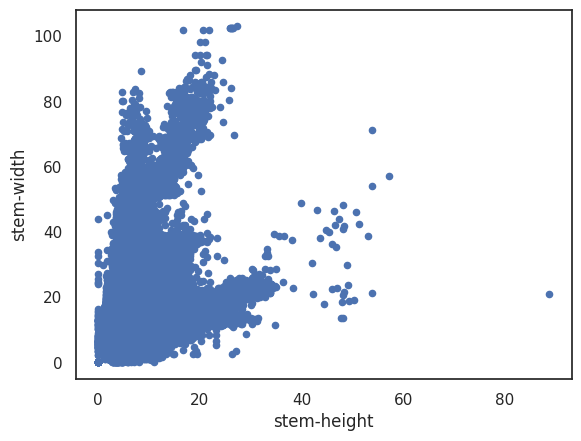

In [10]:
train.plot(kind="scatter", x="stem-height", y="stem-width")

<Axes: xlabel='stem-height', ylabel='stem-width'>

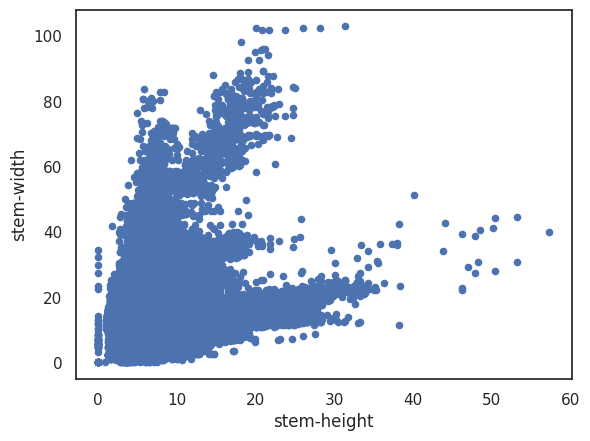

In [11]:
test.plot(kind="scatter", x="stem-height", y="stem-width")

<Axes: xlabel='cap-diameter', ylabel='stem-width'>

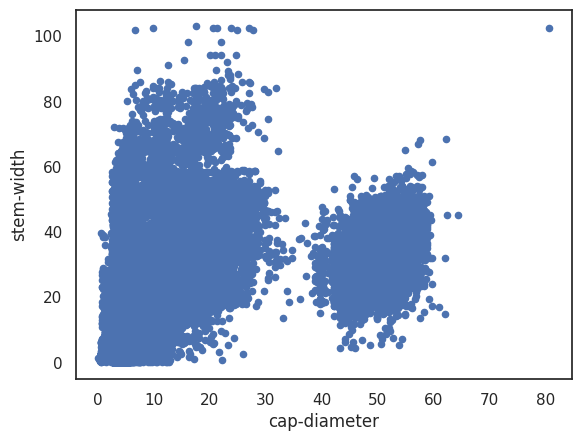

In [12]:
train.plot(kind="scatter", x="cap-diameter", y="stem-width")

<Axes: xlabel='cap-diameter', ylabel='stem-width'>

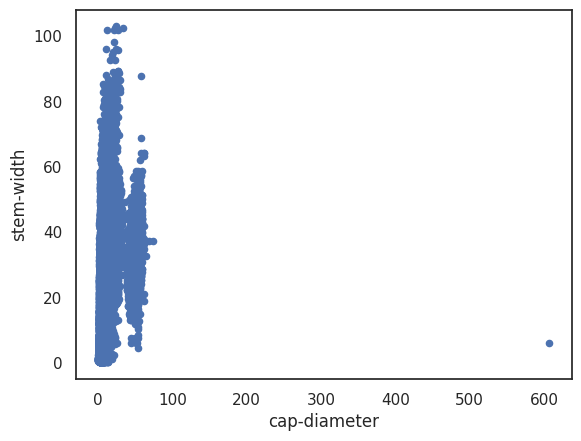

In [13]:
test.plot(kind="scatter", x="cap-diameter", y="stem-width")

<Axes: xlabel='stem-height', ylabel='cap-diameter'>

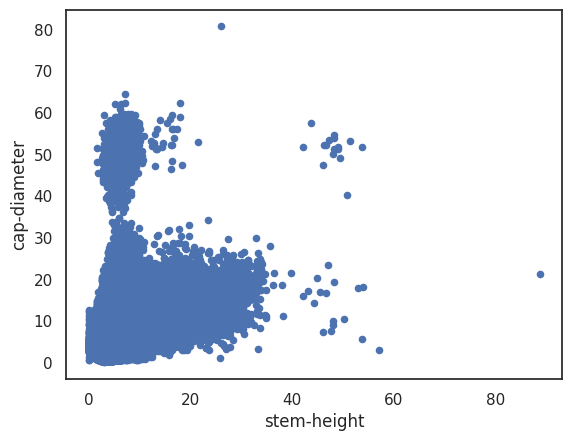

In [14]:
train.plot(kind="scatter", x="stem-height", y="cap-diameter")

<Axes: xlabel='stem-height', ylabel='cap-diameter'>

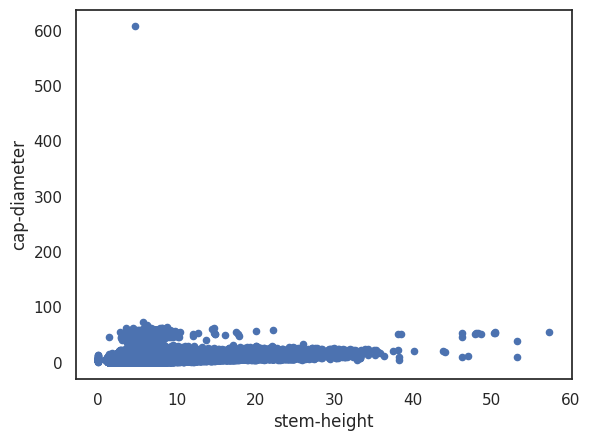

In [15]:
test.plot(kind="scatter", x="stem-height", y="cap-diameter")

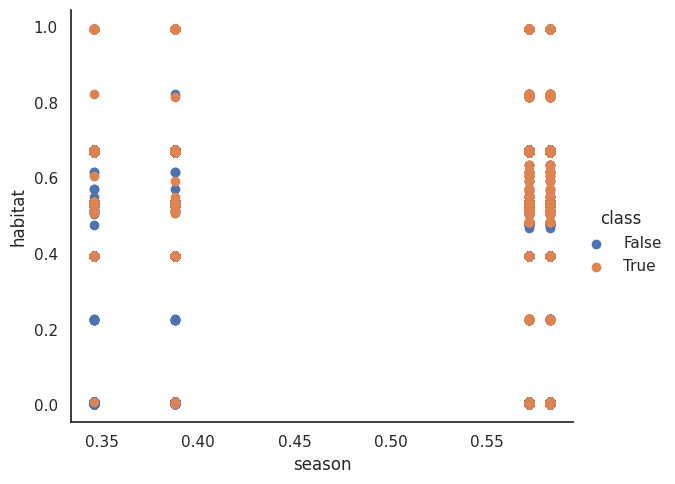

In [16]:
g = sns.FacetGrid(train, hue="class", height=5, aspect=1.2)
g.map(plt.scatter, "season", "habitat")
g.add_legend()

plt.show()
# Here True = Poisonious, False = Edible

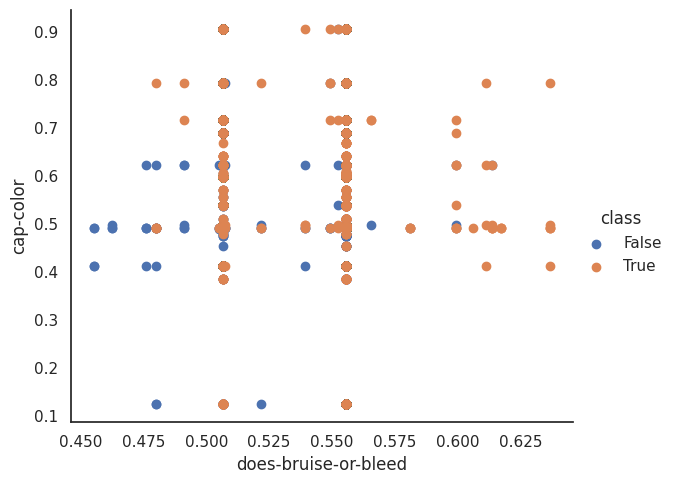

In [17]:
g = sns.FacetGrid(train, hue="class", height=5, aspect=1.2)
g.map(plt.scatter, "does-bruise-or-bleed", "cap-color")
g.add_legend()

plt.show()
# Here True = Poisonious, False = Edible

**As we have outliers in our data and we don't want to lose or manipulate the data then we can use tree based classification algorithms which are resistant to outliers.**

# Split Training Data

In [18]:
X = train.drop(['class'], axis=1)
y = train['class']

# Use XGBClassifier for Prediction

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=5)

clf = xgb.XGBClassifier(
    max_depth=8,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    learning_rate=0.1,    
    n_estimators=2000,    # Start with a large number and use early stopping
    random_state=5,
    device="cuda", 
    tree_method = "hist",
    eval_metric="logloss",      # Metric to evaluate
)

preds=clf.fit(X_train, y_train, 
        eval_set=[(X_val, y_val)],  # Validation data to monitor
        early_stopping_rounds=10,   # Stop if no improvement in 10 rounds
        verbose=True)               # Print progress

preds = clf.predict(test)
sample_submission['class'] = preds
sample_submission['class'] = sample_submission['class'].replace({1: 'p', 0: 'e'})
sample_submission.to_csv('submission.csv')

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.62557
[1]	validation_0-logloss:0.56811
[2]	validation_0-logloss:0.51774
[3]	validation_0-logloss:0.47704
[4]	validation_0-logloss:0.43927
[5]	validation_0-logloss:0.40400
[6]	validation_0-logloss:0.37508
[7]	validation_0-logloss:0.34716
[8]	validation_0-logloss:0.32438
[9]	validation_0-logloss:0.30188
[10]	validation_0-logloss:0.28276
[11]	validation_0-logloss:0.26523
[12]	validation_0-logloss:0.24723
[13]	validation_0-logloss:0.23563
[14]	validation_0-logloss:0.22327
[15]	validation_0-logloss:0.21224
[16]	validation_0-logloss:0.20270
[17]	validation_0-logloss:0.19240
[18]	validation_0-logloss:0.18371
[19]	validation_0-logloss:0.17685
[20]	validation_0-logloss:0.16723
[21]	validation_0-logloss:0.16229
[22]	validation_0-logloss:0.15408
[23]	validation_0-logloss:0.14933
[24]	validation_0-logloss:0.14167
[25]	validation_0-logloss:0.13791
[26]	validation_0-logloss:0.13266
[27]	validation_0-logloss:0.12755
[28]	validation_0-logloss:0.12382
[29]	validation_0-loglos

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:46:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [20]:
sample_submission.head(5)

,class
id,
3116945,e
3116946,p
3116947,p
3116948,p
3116949,e


**Upvote if it helped.** 

Thank you!

Have a wonderful day